In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm_notebook

from fastai.conv_learner import ConvLearner
from fastai.dataset import ImageClassifierData, get_cv_idxs
from fastai.transforms import tfms_from_model

/Users/lex/anaconda3/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/lex/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline

# Lesson 4 - Adding Dropout to spreadsheet CNN

In [3]:
PATH = Path('./data/mnist')
PATH.mkdir(exist_ok=True)

## Dataset

In [5]:
!kaggle competitions download -c digit-recognizer --path={PATH}

In [6]:
df = pd.read_csv(PATH/'train.csv')

### Load a single image

In [153]:
img_pixels = df.loc[7, [c for c in df.columns if c.startswith('pixel')]]
img_arr = np.array([int(i) for i in img_pixels])
img_arr = img_arr.reshape((28, 28))
img_arr_float = img_arr / 255.

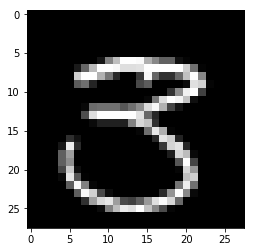

In [155]:
plt.imshow(img_arr_float, cmap='gray')
plt.show()

In [156]:
img_arr_float = img_arr_float.reshape(1, 28, 28)
img_tensor = torch.from_numpy(img_arr_float)
img_tensor = img_tensor.unsqueeze(0).cpu().float()

### Exploring new model

I'll start by improving the model by adding 2 things:
  1. Much more output channels in CNN, from 2 to 32 in the first layer and 2 to 64 in the second layer.
  2. An extra fully-connected layer on the end.

Let's make sure the outputs are as we expect:

In [157]:
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

In [172]:
output = conv1(Variable(img_tensor))

In [173]:
output.shape

torch.Size([1, 32, 28, 28])

Note how I've added 1 pixel of padding on both sides of the output.

This means that the conv will return the same size image output, which is slightly easier to deal with. We then know that the Maxpool will return the size by half:

In [174]:
output = F.max_pool2d(output, 2)

In [175]:
output.shape

torch.Size([1, 32, 14, 14])

We are also adding Dropout. Let's explore what Dropout with 100% probability will look like.

First, let's see the output image:

In [176]:
output[0]

Variable containing:
(0 ,.,.) = 
  2.1169e-01  2.1169e-01  2.1169e-01  ...   2.1169e-01  2.1169e-01  2.1169e-01
  2.1169e-01  2.1169e-01  2.1169e-01  ...   2.1169e-01  2.1169e-01  2.1169e-01
  2.1169e-01  2.1169e-01  2.1169e-01  ...   2.1169e-01  2.1169e-01  2.1169e-01
                 ...                   ⋱                   ...                
  2.1169e-01  2.1409e-01  2.3400e-01  ...   4.1716e-01  2.1169e-01  2.1169e-01
  2.1169e-01  2.1169e-01  2.3423e-01  ...   2.1843e-01  2.1169e-01  2.1169e-01
  2.1169e-01  2.1169e-01  2.1169e-01  ...   2.1169e-01  2.1169e-01  2.1169e-01

(1 ,.,.) = 
  9.6191e-02  9.6191e-02  9.6191e-02  ...   9.6191e-02  9.6191e-02  9.6191e-02
  9.6191e-02  9.6191e-02  9.6191e-02  ...   9.6191e-02  9.6191e-02  9.6191e-02
  9.6191e-02  9.6191e-02  9.6191e-02  ...   9.6191e-02  9.6191e-02  9.6191e-02
                 ...                   ⋱                   ...                
  9.6191e-02  9.6191e-02  1.0339e-02  ...   1.2410e-01  9.6191e-02  9.6191e-02
  9.61

Let's now create Dropout with 100% prob:

In [189]:
dropout = nn.Dropout(p=1)

In [190]:
dropout_output = dropout(output)

In [191]:
dropout_output[0]

Variable containing:
(0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(1 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
     ...       ⋱       ...    
  -0  -0   0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
...

(29,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(30,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0

Notice how all the activations are 0? What about 0.5?

In [192]:
dropout = nn.Dropout(p=0.5)
dropout_output = dropout(output)

In [193]:
dropout_output[0]

Variable containing:
(0 ,.,.) = 
  0.4234  0.4234  0.4234  ...   0.4234  0.0000  0.0000
  0.4234  0.4234  0.4234  ...   0.0000  0.4234  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.4234  0.4234
           ...             ⋱             ...          
  0.4234  0.0000  0.0000  ...   0.8343  0.0000  0.4234
  0.4234  0.4234  0.0000  ...   0.4369  0.4234  0.4234
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.4234

(1 ,.,.) = 
  0.0000  0.1924  0.0000  ...   0.0000  0.1924  0.1924
  0.1924  0.0000  0.1924  ...   0.0000  0.1924  0.1924
  0.1924  0.1924  0.0000  ...   0.1924  0.0000  0.0000
           ...             ⋱             ...          
  0.1924  0.0000  0.0207  ...   0.0000  0.1924  0.0000
  0.1924  0.1924  0.0000  ...   0.1976  0.0000  0.1924
  0.1924  0.0000  0.0000  ...   0.0000  0.0000  0.0000

(2 ,.,.) = 
 -0.0000 -0.0000 -0.4397  ...  -0.4397 -0.0000 -0.0000
 -0.4397 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.4397
 -0.4397 -0.4397 -0.4397  ...  -0.0000 -0.0000 -0.4397
      

Now, 50% of the activations are dropped out.

In [135]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, p=0.5):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
       
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv2_dropout = nn.Dropout(p=p)

        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=1024)
        self.fc1_dropout = nn.Dropout(p=p)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self, img_batch):
        conv1_output = self.conv1(img_batch)
        conv1_relu_output = F.relu(conv1_output)
        maxpool1_output = F.max_pool2d(conv1_relu_output, kernel_size=2)
        
        conv2_output = self.conv2(maxpool1_output)
        relu2_output = F.relu(conv2_output)
        maxpool2_output = F.max_pool2d(relu2_output, kernel_size=2)
        dropout2_output = self.conv2_dropout(maxpool2_output)
        
        flattened_output = dropout2_output.view(img_batch.size(0), -1)
        
        fc1_output = self.fc1(flattened_output)
        fc1_relu_output = F.relu(fc1_output)
        
        fc1_dropout_output = self.fc1_dropout(fc1_relu_output)
        fc2_output = self.fc2(fc1_dropout_output)
        return F.log_softmax(fc2_output, dim=1)

## Train with Fast.ai ConvLearner (no dropout)

I can then create a ImageClassifierData object as usual, use the `from_model_data` constructor to create a `ConvLearner` from my custom model.

In [15]:
train_df = pd.read_csv(PATH/'train_prepared.csv')

In [16]:
val_idx = get_cv_idxs(len(train_df))

Let's start with a CNN that drops activations with a probability of 0% (ie no Dropout).

In [136]:
cnn = SimpleCNN(in_channels=3, p=0.)

In [137]:
cnn

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout(p=0.0)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc1_dropout): Dropout(p=0.0)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [138]:
data = ImageClassifierData.from_csv(
    PATH, 'train', PATH/'train_prepared.csv', tfms=tfms_from_model(cnn, 28), val_idxs=val_idx, suffix='.jpg')

In [139]:
conv_learner = ConvLearner.from_model_data(cnn, data)

In [140]:
conv_learner.lr_find()

 71%|███████   | 374/525 [00:29<00:12, 12.53it/s, loss=1.13] 

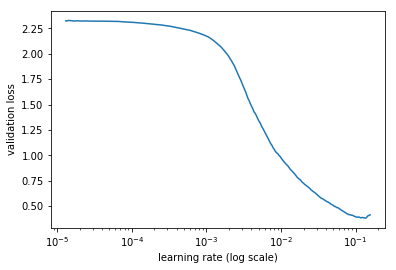

In [141]:
conv_learner.sched.plot()

In [29]:
conv_learner.fit(0.05, 10)

epoch      trn_loss   val_loss   accuracy                     
    0      0.089397   0.112462   0.963333  
    1      0.065815   0.067821   0.980595                     
    2      0.041379   0.061611   0.981071                     
    3      0.036552   0.074447   0.978214                     
    4      0.036247   0.060566   0.985952                     
    5      0.020039   0.048966   0.987976                     
    6      0.034077   0.095807   0.977381                      
    7      0.020217   0.057499   0.986071                     
    8      0.021807   0.075542   0.985595                     
    9      0.047973   0.133513   0.976548                     


[array([0.13351]), 0.976547619047619]

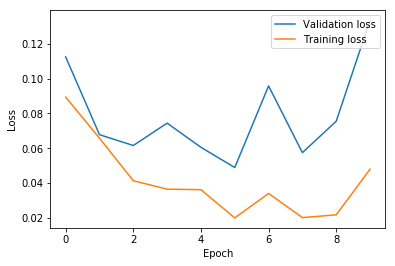

In [101]:
epoch_num = list(range(conv_learner.sched.epoch))
plt.plot(epoch_num, conv_learner.sched.val_losses, label='Validation loss')
plt.plot(
    epoch_num,
    [conv_learner.sched.losses[i-1] for i in conv_learner.sched.epochs],
    label='Training loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Train with Dropout

Let's add a bit of dropout. Set it initially to 0.4 and see if we can train a bit longer before we start to overfit.

In [142]:
cnn = SimpleCNN(in_channels=3, p=0.5)

In [143]:
cnn

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc1_dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [144]:
conv_learner = ConvLearner.from_model_data(cnn, data)

In [145]:
conv_learner.lr_find()

epoch      trn_loss   val_loss   accuracy                    
    0      2.480965   3.082173   0.111548  


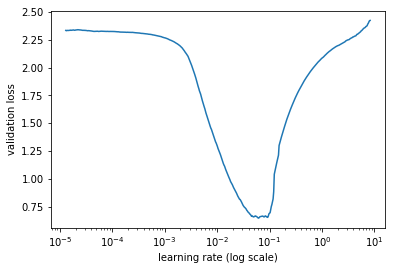

In [146]:
conv_learner.sched.plot()

In [147]:
conv_learner.fit(0.01, 10)

epoch      trn_loss   val_loss   accuracy                    
    0      0.135178   0.067422   0.98      
    1      0.097621   0.054712   0.982976                     
    2      0.080287   0.048799   0.984048                     
    3      0.069733   0.040563   0.987381                     
    4      0.05925    0.032146   0.989524                     
    5      0.050756   0.034987   0.98869                      
    6      0.048073   0.029558   0.99131                      
    7      0.03602    0.028385   0.990833                     
    8      0.036472   0.026458   0.991548                     
    9      0.037791   0.027421   0.99119                      


[array([0.02742]), 0.9911904761904762]

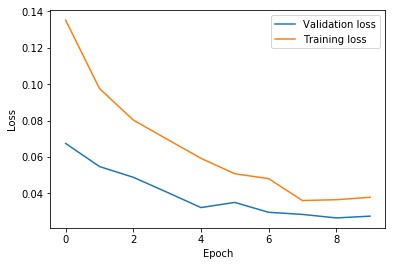

In [148]:
epoch_num = list(range(conv_learner.sched.epoch))
plt.plot(epoch_num, conv_learner.sched.val_losses, label='Validation loss')
plt.plot(
    epoch_num,
    [conv_learner.sched.losses[i-1] for i in conv_learner.sched.epochs],
    label='Training loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Evalute on the test set

In [200]:
test_df = pd.read_csv(PATH/'test.csv')

In [201]:
img_1 = test_df.loc[6, [c for c in df.columns if c.startswith('pixel')]]
img_arr = np.array(img_1)
img_arr = img_arr.reshape((28, 28))
img_float = np.array(img_arr) * (1/255)
img_float = np.stack((img_float,) * 3, axis=-1)
img_float = img_float.transpose((2, 0, 1))
img_tensor = torch.from_numpy(img_float)
img_tensor = img_tensor.unsqueeze(0).cpu().float()

In [202]:
preds = torch.exp(conv_learner.model(Variable(img_tensor)))

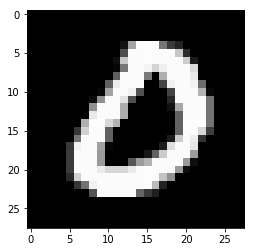

In [203]:
plt.imshow(img_arr, cmap='gray')

In [204]:
preds

Variable containing:
 0.9273  0.0032  0.0162  0.0028  0.0042  0.0016  0.0131  0.0046  0.0128  0.0142
[torch.FloatTensor of size 1x10]

In [205]:
np.argmax(torch.exp(preds.data).numpy())

0